(393732, 7)
88751


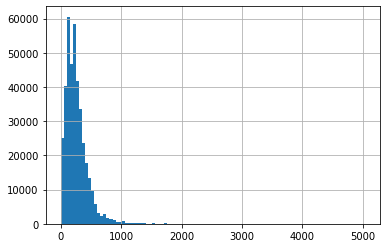

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

df = pd.read_csv('2018-06-06-ss.cleaned.csv') # read in CSV

df.len.hist(bins=100) # histogram graph
print(df.shape)

def seq2ngrams(seqs, n=3):
    return np.array([[seq[i:i+n] for i in range(len(seq))] for seq in seqs])

maxlen_seq = 128
input_seqs, target_seqs = df[['seq', 'sst3']][(df.len <= maxlen_seq) & (~df.has_nonstd_aa)].values.T
input_grams = seq2ngrams(input_seqs)
# print(input_seqs, input_grams)
print(len(input_seqs))

In [2]:
from keras.preprocessing import text, sequence

from keras.preprocessing.sequence import pad_sequences

from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical

tokenizer_encoder = Tokenizer() # Tokenizer Class Instance

tokenizer_encoder.fit_on_texts(input_grams) # tokenize the input_grams 

input_data = tokenizer_encoder.texts_to_sequences(input_grams) 

# print(input_data)

input_data = pad_sequences(input_data, maxlen=maxlen_seq, padding='post') # padding the end so length is same

tokenizer_decoder = Tokenizer(char_level=True)

tokenizer_decoder.fit_on_texts(target_seqs)

target_data = tokenizer_decoder.texts_to_sequences(target_seqs)

target_data = pad_sequences(target_data, maxlen=maxlen_seq, padding='post')

target_data = to_categorical(target_data)

input_data.shape, target_data.shape

((88751, 128), (88751, 128, 4))

In [4]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Bidirectional

n_words = len(tokenizer_encoder.word_index) + 1

n_tags = len(tokenizer_decoder.word_index) + 1
print(n_words, n_tags)

input = Input(shape=(maxlen_seq,))
x = Embedding(input_dim=n_words, output_dim=128, input_length=maxlen_seq)(input)
x = Bidirectional(LSTM(units=64, return_sequences=True, recurrent_dropout=0.1))(x)
y = TimeDistributed(Dense(n_tags, activation="softmax"))(x)
model = Model(input, y)
model.summary()

8421 4
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 128, 128)          1077888   
_________________________________________________________________
bidirectional (Bidirectional (None, 128, 128)          98816     
_________________________________________________________________
time_distributed (TimeDistri (None, 128, 4)            516       
Total params: 1,177,220
Trainable params: 1,177,220
Non-trainable params: 0
_________________________________________________________________


In [5]:
from sklearn.model_selection import train_test_split
from keras.metrics import categorical_accuracy
from keras import backend as K
import tensorflow as tf

def q3_acc(y_true, y_pred):
    y = tf.argmax(y_true, axis=-1)
    y_ = tf.argmax(y_pred, axis=-1)
    mask = tf.greater(y, 0)
    return K.cast(K.equal(tf.boolean_mask(y, mask), tf.boolean_mask(y_, mask)), K.floatx())

model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy", q3_acc])

X_train, X_test, y_train, y_test = train_test_split(input_data, target_data, test_size=.4, random_state=0)
seq_train, seq_test, target_train, target_test = train_test_split(input_seqs, target_seqs, test_size=.4, random_state=0)

model.fit(X_train, y_train, batch_size=128, epochs=5, validation_data=(X_test, y_test), verbose=1)

Epoch 1/5
417/417 [==============================] - 320s 768ms/step - loss: 0.4039 - accuracy: 0.8300 - q3_acc: 0.7306 - val_loss: 0.3285 - val_accuracy: 0.8644 - val_q3_acc: 0.7850
Epoch 2/5
417/417 [==============================] - 346s 831ms/step - loss: 0.2756 - accuracy: 0.8913 - q3_acc: 0.8267 - val_loss: 0.2735 - val_accuracy: 0.8924 - val_q3_acc: 0.8295
Epoch 3/5
417/417 [==============================] - 360s 862ms/step - loss: 0.2408 - accuracy: 0.9057 - q3_acc: 0.8497 - val_loss: 0.2490 - val_accuracy: 0.9034 - val_q3_acc: 0.8470
Epoch 4/5
417/417 [==============================] - 369s 885ms/step - loss: 0.2183 - accuracy: 0.9149 - q3_acc: 0.8643 - val_loss: 0.2484 - val_accuracy: 0.9036 - val_q3_acc: 0.8471
Epoch 5/5
417/417 [==============================] - 386s 926ms/step - loss: 0.2015 - accuracy: 0.9217 - q3_acc: 0.8752 - val_loss: 0.2263 - val_accuracy: 0.9129 - val_q3_acc: 0.8619


training
---
Input: MGDKPIWEQIGSSFINHYYQLFDNDRTQLGAIYIDASCLTWEGQQFQGKAAIVEKLSSLPFQKIQHSITAQDHQPTPDSCIISMVVGQLKADEDPIMGFHQEFLLKNINDAWVCTNDMFRLALHNFG
Target: CCCCCHHHHHHHHHHHHHHHHHHHCHHHHHHHCCCCCEEEECCEEEECHHHHHHHHHHCCCCCEEEEEEEEEEEECCCCCEEEEEEEEEEECCCCCEEEEEEEEEEECCCCEEEEEEEEEEECCCCC
Result: CCCCCHHHHHHHHHHHHHHHHHHHCHHHHCHEEEEEEEEEEECEEEECHHHHHHHHHCCCCCCEEEEEEEEEEEECCCCCEEEEEEEEEEEECCCEEEEEEEEEEEEECCCEEEEEEEEEEECCCCC


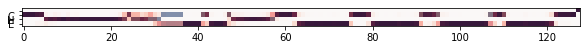

---
Input: SRGTQTE
Target: CEEEECC
Result: CCCCCCC


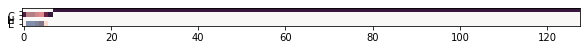

---
Input: MKEEKRSSTGFLVKQRAFLKLYMITMTEQERLYGLKLLKVLQSEFKEIGFKPNHTEVYRSLHELLDDGILKQIKVKKEGAKLQEVVLYQFKDYEAAKLYKKQLKVELDRCKKLIEKALSDNF
Target: CCCCCCCCCCCCCCHHHHHHHHHHHHHHCCCEECCCCHHHHHHHHCCCCCCCCHHHHHHHHHHHHHCCCEEEEECCCCCCCCCCCEEEEECCHHHHHHHHHHHHHHHHHHHHHHHHHHHHHC
Result: CCCCCCCCCCCCCHHHHHHHHHHHHHHHHHHCCCHHHHHHHHHHHCCCCCCCCHHHHHHHHHHHHCHCCHEEEEECCCCCCCCCEEEEECHCHHHHHHHHHHHHHHHHHHHHHHHHHHHCCC


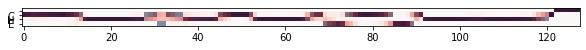

testing
---
Input: MKRQKRDRLERAHQRGYQAGIAGRSKEMCPYQTLNQRSQWLGGWREAMADRVVMAHHHHHH
Target: CCCCCHHHHHHHHHHHHHHHHCCCCCCCCCCCCHHHHHHHHHHHHHHHHHCCCCCCCCCCC
Result: CCCCHHHHHHHHHHHHHHHHHHCCCHHCCCHHHHHHHHHHHHHHHHHHHHHHCCCCCCCCC


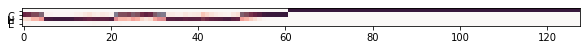

---
Input: YCQKWMWTCDEERKCCEGLVCRLWCKRIINM
Target: CCCCCCCECCCCCCCCCCCECCCECECCCCC
Result: CCCCCEEECCCCCEEECCCCCEEEEEEEEEC


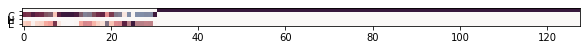

---
Input: TEFSEEQKRTLDLLFLFDRRMTEERRRWLSQRLGLNEEQIERWFRRKEQQI
Target: CCCCCCHHHHHHHHHHHHHHHHHHHHHHHHHHCCCCHHHHHHHHHCCCCCC
Result: CCCCHHHHHHHHHHHHHHHHHHHHHHHHHHHHCCCCHHHHHHHHHHHCCCC


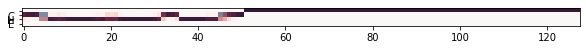

In [6]:
def onehot_to_seq(oh_seq, index):
    s = ''
    for o in oh_seq:
        i = np.argmax(o)
        if i != 0:
            s += index[i]
        else:
            break
    return s

def plot_results(x, y, y_):
    print("---")
    print("Input: " + str(x))
    print("Target: " + str(onehot_to_seq(y, revsere_decoder_index).upper()))
    print("Result: " + str(onehot_to_seq(y_, revsere_decoder_index).upper()))
    fig = plt.figure(figsize=(10,2))
    plt.imshow(y.T, cmap='Blues')
    plt.imshow(y_.T, cmap='Reds', alpha=.5)
    plt.yticks(range(4), [' '] + [revsere_decoder_index[i+1].upper() for i in range(3)])
    plt.show()
    
revsere_decoder_index = {value:key for key,value in tokenizer_decoder.word_index.items()}
revsere_encoder_index = {value:key for key,value in tokenizer_encoder.word_index.items()}

N=3
y_train_pred = model.predict(X_train[:N])
y_test_pred = model.predict(X_test[:N])
print('training')
for i in range(N):
    plot_results(seq_train[i], y_train[i], y_train_pred[i])
print('testing')
for i in range(N):
    plot_results(seq_test[i], y_test[i], y_test_pred[i])
    
    